#Build a Question/Answering system over SQL data


 In this guide we'll go over the basic ways to create a Q&A system over tabular data in databases. We will cover implementations using both chains and agents. These systems will allow us to ask a question about the data in a database and get back a natural language answer.The main difference between the two is that our agent can query the database in a loop as many times as it needs to answer the question.

Building Q&A systems of SQL databases requires executing model-generated SQL queries. There are inherent risks in doing this.

##Architecture

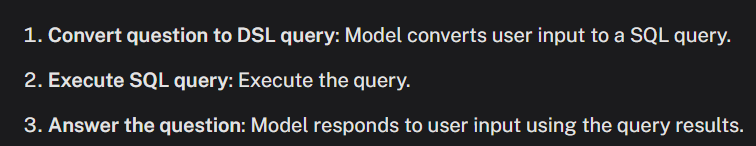

Note that querying data in CSVs can follow a similar approach.

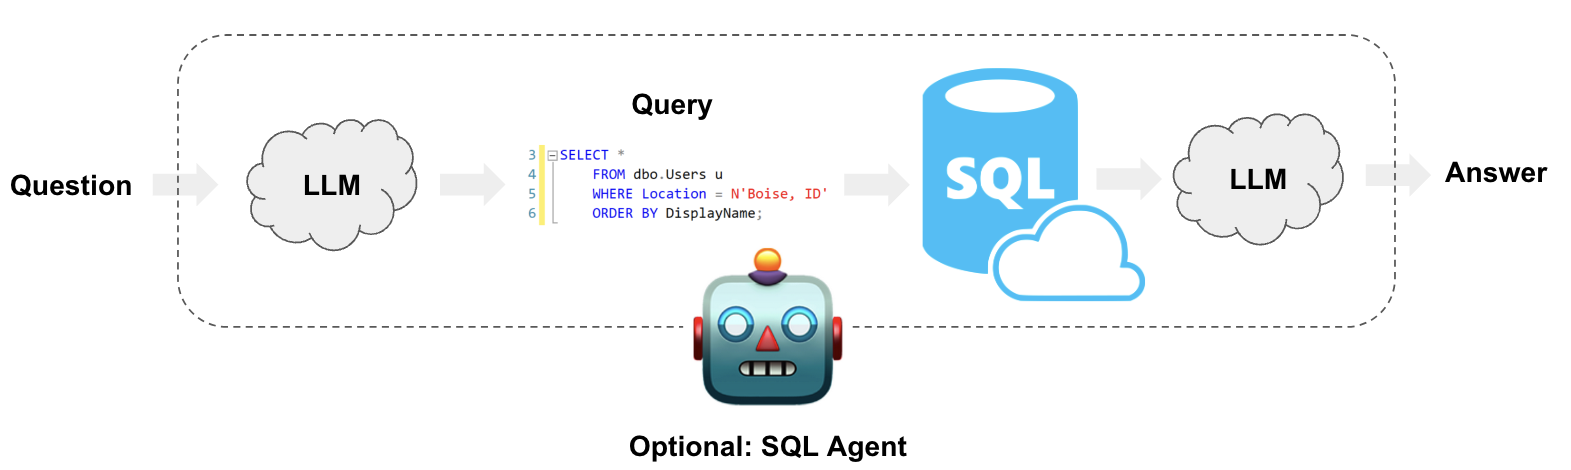

In [1]:
!pip install --upgrade --quiet  langchain langchain-community langchain-google-genai langchain_core google-cloud-aiplatform langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 4.5 MB/s eta 0:00:00


In [133]:
from langchain_google_genai import ChatGoogleGenerativeAI

import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

SQLite connection with Chinook database:


In [22]:
import sqlite3

conn = sqlite3.connect('Chinook.db')
cursor = conn.cursor()

with open('/content/Chinook_Sqlite.sql', 'r') as sql_file:
    sql_script = sql_file.read()

cursor.executescript(sql_script)

conn.commit()

conn.close()

In [24]:
conn = sqlite3.connect('Chinook.db')

cursor = conn.cursor()
cursor.execute("SELECT * FROM Artist LIMIT 10;")
results = cursor.fetchall()
for row in results:
    print(row)
cursor.close()
conn.close()

(1, 'AC/DC')
(2, 'Accept')
(3, 'Aerosmith')
(4, 'Alanis Morissette')
(5, 'Alice In Chains')
(6, 'Antônio Carlos Jobim')
(7, 'Apocalyptica')
(8, 'Audioslave')
(9, 'BackBeat')
(10, 'Billy Cobham')


In [26]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:////content/Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

###Chains

Chains (i.e., compositions of LangChain Runnables) support applications whose steps are predictable.

###Convert question to SQL query

In [89]:
def clean_sql_query(query):
    """
    Removes 'sqlite\n' and '\n' from the provided SQL query string.

    Parameters:
    query (str): The SQL query string to be cleaned.

    Returns:
    str: The cleaned SQL query string.
    """
    cleaned_query = query.replace('sqlite\n', '').replace('\n', '').replace('```', '')
    return cleaned_query.strip()

# Example usage:
sql_query = "```sqlite\nSELECT COUNT(*) FROM Employee\n```"
cleaned_query = clean_sql_query(sql_query)
print(cleaned_query)  # Output: "SELECT COUNT(*) FROM Employee"

SELECT COUNT(*) FROM Employee


In [136]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [137]:
from langchain.chains import create_sql_query_chain

chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "How many employees are there?"})
response

'```sqlite\nSELECT COUNT(*) FROM Employee\n```'

In [138]:
clean_sql_query(response)

'SELECT COUNT(*) FROM Employee'

In [139]:
from langchain_core.runnables import RunnableLambda

parsed_chain = chain | RunnableLambda(clean_sql_query)

In [140]:
response = parsed_chain.invoke({"question": "How many employees are there?"})

In [141]:
response

'SELECT COUNT(*) FROM Employee'

In [142]:
db.run(response)

'[(8,)]'

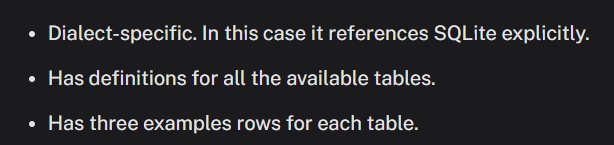

In [96]:
chain.get_prompts()[0].pretty_print()

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result

In [144]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

execute_query = QuerySQLDataBaseTool(db=db)
chain = parsed_chain | execute_query
chain.invoke({"question": "How many employees are there?"})

'[(8,)]'

###Answer the question

In [145]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, and SQL result, answer the user question.

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: """
)

chain = (
    RunnablePassthrough.assign(query=parsed_chain).assign(
        result=itemgetter("query") | execute_query
    )
    | answer_prompt
    | llm
    | StrOutputParser()
)

chain.invoke({"question": "How many employees are there?"})

'There are **8** employees. \n'

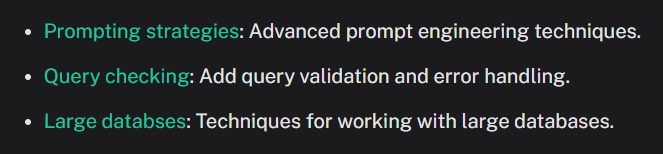

#Agents

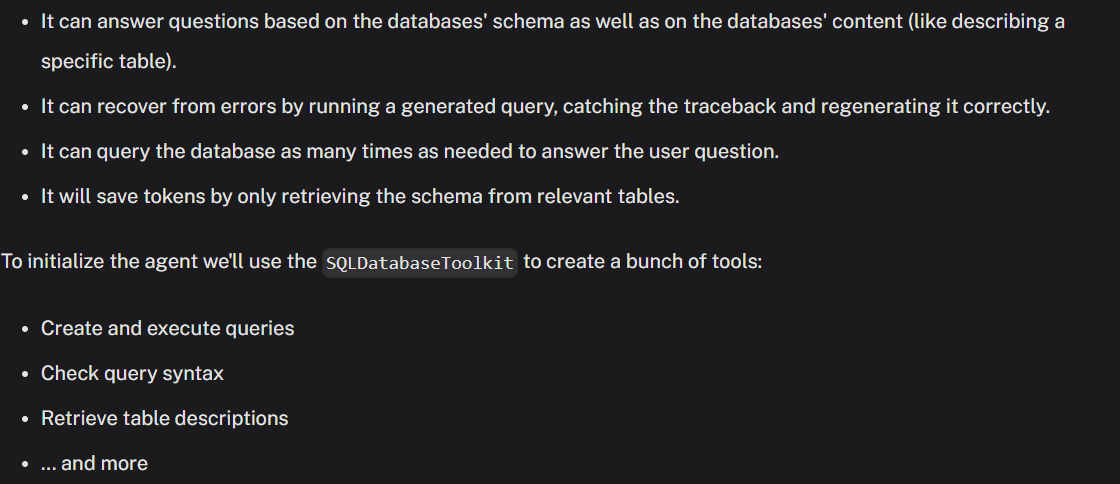

In [146]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7db0213d9ae0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7db0213d9ae0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7db0213d9ae0>),
 QuerySQLCheckerTool(description='Use this tool to double check

##System Prompt

In [147]:
from langchain_core.messages import SystemMessage

SQL_PREFIX = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables."""

system_message = SystemMessage(content=SQL_PREFIX)

In [149]:
!pip install httpx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00


In [150]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, messages_modifier=system_message)

In [151]:
for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Which country's customers spent the most?")]}
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'sql_db_list_tables', 'arguments': '{"tool_input": ""}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-61cc9c88-0e4d-4820-a94b-52189faf116e-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {'tool_input': ''}, 'id': '0950a0e7-3f5a-485d-b6aa-76829cdf5586'}], usage_metadata={'input_tokens': 623, 'output_tokens': 19, 'total_tokens': 642})]}}
----
{'tools': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, 

In [152]:
for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Describe the playlisttrack table")]}
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'sql_db_list_tables', 'arguments': '{"tool_input": ""}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-ab87f38c-4ce6-4911-93e6-ce0b640a9d78-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {'tool_input': ''}, 'id': '153a2263-6236-4513-98dc-77273e351966'}], usage_metadata={'input_tokens': 619, 'output_tokens': 19, 'total_tokens': 638})]}}
----
{'tools': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, 

###Dealing with high-cardinality columns

In order to filter columns that contain proper nouns such as addresses, song names or artists, we first need to double-check the spelling in order to filter the data correctly.

We can achieve this by creating a vector store with all the distinct proper nouns that exist in the database. We can then have the agent query that vector store each time the user includes a proper noun in their question, to find the correct spelling for that word. In this way, the agent can make sure it understands which entity the user is referring to before building the target query.

In [153]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['Back to Black',
 'Machine Head',
 "Tchaikovsky:  Festival Overture, Op., Capriccio Italien & Beethoven: Wellington's Victory",
 'The World of Classical Favourites',
 'Mozart Gala: Famous Arias']

In [155]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 5.0 MB/s eta 0:00:00


In [156]:
from langchain.agents.agent_toolkits import create_retriever_tool
from langchain_community.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings

vector_db = FAISS.from_texts(artists + albums, GoogleGenerativeAIEmbeddings(model="models/embedding-001"))
retriever = vector_db.as_retriever(search_kwargs={"k": 5})
description = """Use to look up values to filter on. Input is an approximate spelling of the proper noun, output is \
valid proper nouns. Use the noun most similar to the search."""
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

In [157]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Carried to Dust (Bonus Track Version)

No More Tears (Remastered)

Unplugged [Live]

Pure Cult: The Best Of The Cult (For Rockers, Ravers, Lovers & Sinners) [UK]


In [161]:
system = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

You have access to the following tables: {table_names}

If you need to filter on a proper noun, you must ALWAYS first look up the filter value using the "search_proper_nouns" tool!
Do not try to guess at the proper name - use this function to find similar ones.""".format(
    table_names=db.get_usable_table_names()
)

system_message = SystemMessage(content=system)

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, messages_modifier=system_message)

In [162]:
for s in agent.stream(
    {"messages": [HumanMessage(content="How many albums does alis in chain have?")]}
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search_proper_nouns', 'arguments': '{"query": "alis in chain"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-20e42d96-a647-432c-a8b1-e8e8355d0757-0', tool_calls=[{'name': 'search_proper_nouns', 'args': {'query': 'alis in chain'}, 'id': 'b292f152-95a9-443a-8114-9a81c8ff6d10'}], usage_metadata={'input_tokens': 825, 'output_tokens': 20, 'total_tokens': 845})]}}
----
{'tools': {'messages': [ToolMessage(content='Alice In Chains\n\nCássia Eller -